# Add Folders to Path

In [1]:
%%time
import sys, os
# get current directory
path = os.getcwd()
# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-2])
# add Algorithm folder to current working path in order to access the functions inside the folder ´Algorithms´
sys.path.append(parent_directory+"/General_Functions")

CPU times: user 284 µs, sys: 211 µs, total: 495 µs
Wall time: 378 µs


# Agulhas

## Import data

In [2]:
%%time
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../Data/Agulhas_AVISO.mat')

U = mat_file['u']
V = mat_file['v']
x = mat_file['x']
y = mat_file['y']
time = mat_file['t']

CPU times: user 237 ms, sys: 67.7 ms, total: 305 ms
Wall time: 304 ms


## Data/Parameters for Dynamical System

In [3]:
import numpy as np

# Number of cores to be used for parallel computing
Ncores = 18

# Incompressible/Compressible flow. {True, False}
Incompressible = True

# Periodic boundary conditions
periodic_x = False
periodic_y = False
Periodic = [periodic_x, periodic_y]

## Compute Meshgrid
X, Y = np.meshgrid(x, y)

# List of parameters of the flow.
params_data = {"X": X, "Y": Y, "Time": time, "U": U, "V": V, "Ncores": Ncores, 
               "Incompressible": Incompressible, "Periodic": Periodic}

<a id='Spatio-Temporal-Domain-of-Dynamical-System'></a>
## Spatio-temporal domain of Dynamical System

In [4]:
%%time
# time (in days)
t = 10

time = [t]

# longitudinal and latitudinal boundaries (in degrees)
xmin = 0
xmax = 5
ymin = -35
ymax = -30

# spacing of meshgrid (in degrees)
dx = 0.01
dy = 0.01

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

params_DS = {"time": time, "X_domain": X_domain, "Y_domain": Y_domain}

CPU times: user 1.97 ms, sys: 2.6 ms, total: 4.56 ms
Wall time: 2.52 ms


## Initialize Dynamical System

In [5]:
%%time
from ipynb.fs.defs.DynamicalSystem import *

DS = Dynamical_System(params_data, params_DS)

CPU times: user 96.3 ms, sys: 16.9 ms, total: 113 ms
Wall time: 112 ms


## Velocity interpolation

In [6]:
%%time
# Interpolate velocity data using cubic spatial interpolation
DS._Interpolation_velocity("cubic")

CPU times: user 286 ms, sys: 32.6 ms, total: 319 ms
Wall time: 318 ms


## Compute rate of strain tensor $ S(\mathbf{x},t) $ over meshgrid

In [7]:
%%time
from tqdm.notebook import tqdm

S = np.zeros((X_domain.shape[0], X_domain.shape[1], 2, 2))

for i in tqdm(range(S.shape[0])):
    
    for j in range(S.shape[1]):
        
        x = np.array([X_domain[i,j], Y_domain[i,j]])
        
        S[i, j, :, :] = DS._spin_tensor(x, t)

  0%|          | 0/502 [00:00<?, ?it/s]

CPU times: user 2min 40s, sys: 719 ms, total: 2min 40s
Wall time: 2min 40s


## Instantaneous Finite Time Lyapunov Exponent (IFTLE)

In [8]:
from ipynb.fs.defs.IFTLE import _IFTLE
IFTLE_min, IFTLE_max = _IFTLE(S, Incompressible)

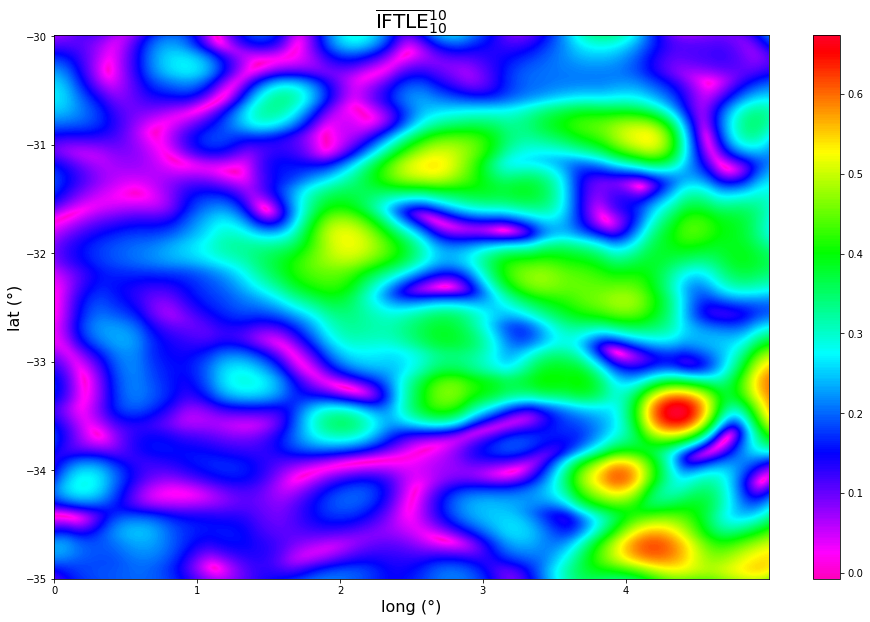

In [15]:
######################## PLOT RESULTS ########################
import matplotlib.pyplot as plt

# Figure/Axes
fig = plt.figure(figsize=(16, 10))
ax = plt.axes()

# Contourplot of TSE over meshgrid of initial conditions
cax = ax.contourf(X_domain, Y_domain, IFTLE_max, cmap = "gist_rainbow_r", levels = 600)

# Axis Labels
ax.set_xlabel("long (°)", fontsize = 16)
ax.set_ylabel("lat (°)", fontsize = 16)

# Ticks
ax.set_xticks(np.arange(np.min(X_domain), np.max(X_domain), 1))
ax.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain), 1))

# Colorbar
cbar = fig.colorbar(cax, ticks = np.linspace(0, .6, 7))

# Title
ax.set_title(r'$ \mathrm{\overline{IFTLE}}$'+f'$_{{{int(time[0])}}}^{{{int(time[-1])}}}$', fontsize = 20)

plt.show()